Install Libraries

In [ ]:
!pip install numpy pandas matplotlib yfinance torch torchbnn seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Download, Preporcess, and Normalize Tesla Stock Data

In [ ]:
# Download Tesla stock data
def load_stock_data(ticker='TSLA', start_date='2015-01-01', end_date='2023-12-31'):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Preprocess data
def preprocess_data(data, lookback=30):
    # Use only closing prices
    prices = data['Close'].values.reshape(-1, 1)

    # Normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    prices_normalized = scaler.fit_transform(prices)

    # Create sequences
    X, y = [], []
    for i in range(len(prices_normalized) - lookback):
        X.append(prices_normalized[i:i+lookback, 0])
        y.append(prices_normalized[i+lookback, 0])

    X = np.array(X)
    y = np.array(y)

    return X, y, scaler

# Load and preprocess data
tsla_data = load_stock_data()
X, y, scaler = preprocess_data(tsla_data)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(-1)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(-1)
y_test_tensor = torch.FloatTensor(y_test)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print shapes
print(f"Train shapes: X - {X_train.shape}, y - {y_train.shape}")
print(f"Test shapes: X - {X_test.shape}, y - {y_test.shape}")

/tmp/ipython-input-3-4039572064.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Train shapes: X - (1787, 30), y - (1787,)
Test shapes: X - (447, 30), y - (447,)


Build the Bayesian Neural Network

In [ ]:
class BayesianNN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32, output_dim=1):
        super(BayesianNN, self).__init__()

        # Bayesian layers
        self.fc1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,
                                  in_features=input_dim, out_features=hidden_dim)
        self.fc2 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,
                                  in_features=hidden_dim, out_features=hidden_dim)
        self.fc3 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,
                                  in_features=hidden_dim, out_features=output_dim)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Flatten time series dimension
        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x.squeeze()

Training!!

In [ ]:
# Initialize model
model = BayesianNN(input_dim=30, hidden_dim=32, output_dim=1)  # input_dim=lookback (30)

# Loss function: ELBO = KL divergence + negative log likelihood
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.1

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training parameters
epochs = 100
train_losses = []
test_losses = []

# Training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_X)

        # Calculate loss
        mse = mse_loss(outputs, batch_y)
        kl = kl_loss(model)
        loss = mse + kl_weight * kl

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Average epoch loss
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)

    # Validation
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            mse = mse_loss(outputs, batch_y)
            kl = kl_loss(model)
            loss = mse + kl_weight * kl
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_epoch_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

Epoch 1/100, Train Loss: 0.0722, Test Loss: 0.0631
Epoch 2/100, Train Loss: 0.0410, Test Loss: 0.1202
Epoch 3/100, Train Loss: 0.0396, Test Loss: 0.1371
Epoch 4/100, Train Loss: 0.0332, Test Loss: 0.0470
Epoch 5/100, Train Loss: 0.0285, Test Loss: 0.0872
Epoch 6/100, Train Loss: 0.0260, Test Loss: 0.0478
Epoch 7/100, Train Loss: 0.0227, Test Loss: 0.0710
Epoch 8/100, Train Loss: 0.0277, Test Loss: 0.0311
Epoch 9/100, Train Loss: 0.0181, Test Loss: 0.0461
Epoch 10/100, Train Loss: 0.0168, Test Loss: 0.0474
Epoch 11/100, Train Loss: 0.0198, Test Loss: 0.0372
Epoch 12/100, Train Loss: 0.0169, Test Loss: 0.0236
Epoch 13/100, Train Loss: 0.0144, Test Loss: 0.0365
Epoch 14/100, Train Loss: 0.0128, Test Loss: 0.0280
Epoch 15/100, Train Loss: 0.0135, Test Loss: 0.0215
Epoch 16/100, Train Loss: 0.0163, Test Loss: 0.0226
Epoch 17/100, Train Loss: 0.0113, Test Loss: 0.0163
Epoch 18/100, Train Loss: 0.0115, Test Loss: 0.0224
Epoch 19/100, Train Loss: 0.0098, Test Loss: 0.0211
Epoch 20/100, Train L

Prediction and Uncertainty Estimation

In [ ]:
def predict_with_uncertainty(model, X, n_samples=100):
    model.eval()
    predictions = []

    with torch.no_grad():
        for _ in range(n_samples):
            outputs = model(X)
            predictions.append(outputs.numpy())

    predictions = np.array(predictions).squeeze()
    mean_prediction = np.mean(predictions, axis=0)
    std_prediction = np.std(predictions, axis=0)

    return mean_prediction, std_prediction

# Get predictions on test set
mean_pred, std_pred = predict_with_uncertainty(model, X_test_tensor)

# Inverse transform to original scale
mean_pred_orig = scaler.inverse_transform(mean_pred.reshape(-1, 1)).flatten()
std_pred_orig = scaler.inverse_transform(std_pred.reshape(-1, 1)).flatten() * scaler.scale_[0]
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate upper and lower bounds
upper_bound = mean_pred_orig + 1.96 * std_pred_orig  # 95% confidence interval
lower_bound = mean_pred_orig - 1.96 * std_pred_orig

Visualize

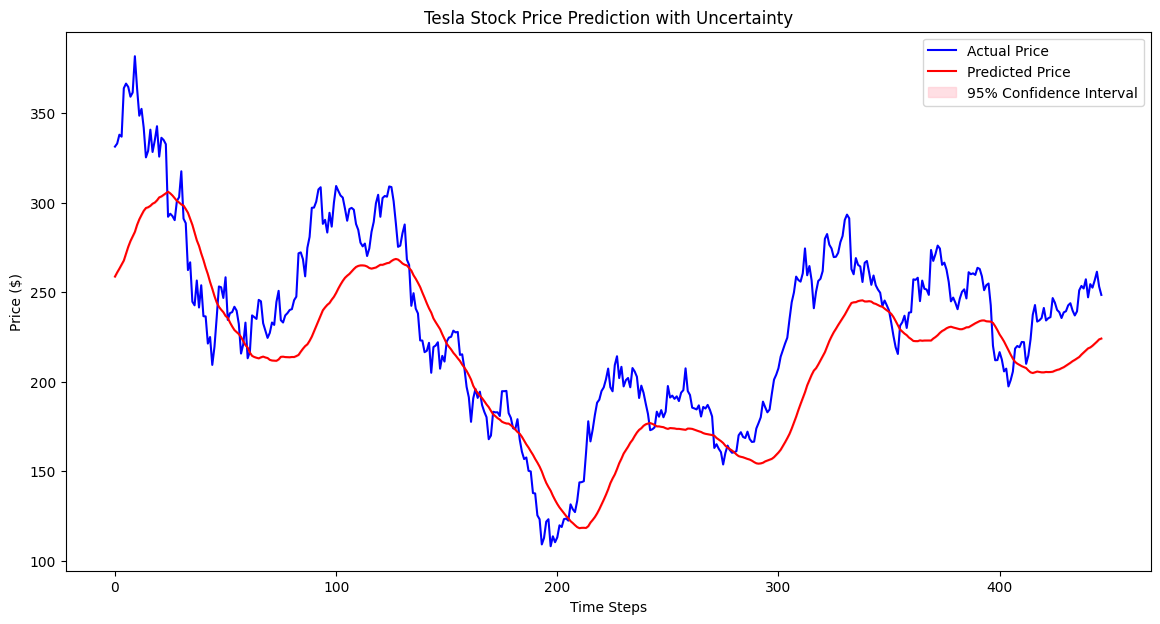

In [ ]:
# Plot results
plt.figure(figsize=(14, 7))
plt.plot(y_test_orig, label='Actual Price', color='blue')
plt.plot(mean_pred_orig, label='Predicted Price', color='red')
plt.fill_between(range(len(y_test_orig)), lower_bound, upper_bound,
                 color='pink', alpha=0.5, label='95% Confidence Interval')
plt.title('Tesla Stock Price Prediction with Uncertainty')
plt.xlabel('Time Steps')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

Evaluation Metircs

In [ ]:
def calculate_log_likelihood(y_true, y_pred_mean, y_pred_std):
    # Calculate log likelihood assuming normal distribution
    log_likelihood = -0.5 * np.sum(np.log(2 * np.pi * y_pred_std**2) +
                                  ((y_true - y_pred_mean) / y_pred_std)**2)
    return log_likelihood

# Calculate log likelihood
log_likelihood = calculate_log_likelihood(y_test_orig, mean_pred_orig, std_pred_orig)
print(f"Log Likelihood: {log_likelihood:.2f}")

# Calculate RMSE
rmse = np.sqrt(np.mean((y_test_orig - mean_pred_orig)**2))
print(f"RMSE: {rmse:.2f}")

# Calculate coverage of 95% confidence interval
coverage = np.mean((y_test_orig >= lower_bound) & (y_test_orig <= upper_bound))
print(f"95% Confidence Interval Coverage: {coverage:.2%}")

Log Likelihood: -31516233.17
RMSE: 33.51
95% Confidence Interval Coverage: 0.67%
